Clustering and classification from feature extracted from tiles of the original WSIs, without applying any kind of normalisation method.

---
# 0. - Imports and paths

In [2]:
import os
import pandas as pd
import matplotlib.font_manager as fm
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from PIL import Image, ImageDraw
import numpy as np
import re
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.cluster import FeatureAgglomeration
from sklearn.decomposition import PCA#, TruncatedSVD
#import umap
import umap.umap_ as umap
from sklearn.manifold import TSNE
from matplotlib.lines import Line2D

/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
os.chdir("/disk2/user/gabgam/work/gigi_env/the_project/4_clustering_and_classification/")
print(os.getcwd())

/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification


In [4]:
# Fetch DM Sans font file from https://github.com/google/fonts/blob/main/ofl/dmsans/DMSans%5Bopsz%2Cwght%5D.ttf or, better, https://fonts.google.com/specimen/DM+Sans
font_path = "../fonts/static/DMSans-Medium.ttf" 

# Add font to matplotlib
try:
    fm.fontManager.addfont(font_path)
    plt.rcParams['font.family'] = 'DM Sans'
except RuntimeError as e:
    print(f"Failed to load font: {e}")

In [5]:
model = "kimianet"

In [6]:
# WIDTH = 1000
# PATH_TO_MERGED_PICKLES = f"output/{model}/satac_C1_v3_allspots_&_visium_2022_FF_WG_10X_img_not_changed_allspots/"
# COMPARISON = "satac_C1_v3_allspots_&_visium_2022_FF_WG_10X_img_not_changed_allspots"

# if WIDTH:
#     SELECTED_PICKLE_100um = f'MERGED_satac_C1_&_v3_allspots__&__visium_2022_FF_WG_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_ORIGINAL WSI_width{WIDTH}.pickle'
#     SELECTED_PICKLE_68um = f'MERGED_satac_C1_&_v3_allspots__&__visium_2022_FF_WG_10X_&_img_not_changed_allspots__for__target_is_reference_full_68um_ORIGINAL WSI_width{WIDTH}.pickle'
# else:
#     SELECTED_PICKLE_100um = 'MERGED_satac_C1_&_v3_allspots__&__visium_2022_FF_WG_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_ORIGINAL WSI.pickle'
#     SELECTED_PICKLE_68um = 'MERGED_satac_C1_&_v3_allspots__&__visium_2022_FF_WG_10X_&_img_not_changed_allspots__for__target_is_reference_full_68um_ORIGINAL WSI.pickle'

In [7]:
WIDTH = 1000
PATH_TO_MERGED_PICKLES = f"output/{model}/satac_C1_v3_allspots_&_visium_FFPE_dcis_idc_10X_img_not_changed_allspots/"
COMPARISON = "satac_C1_v3_allspots_&_visium_FFPE_dcis_idc_10X_img_not_changed_allspots"

if WIDTH:
    SELECTED_PICKLE_100um = f'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_ORIGINAL WSI_width{WIDTH}.pickle'
    SELECTED_PICKLE_68um = f'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_68um_ORIGINAL WSI_width{WIDTH}.pickle'
else:
    SELECTED_PICKLE_100um = 'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_ORIGINAL WSI.pickle'
    SELECTED_PICKLE_68um = 'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_68um_ORIGINAL WSI.pickle'

In [8]:
# path to the target image
PATH_TO_REFERENCE = "../2_image_normalisation/reference_images/reference_full.jpeg"
# `TARGET_IS_<filename>`
TARGET_IS = "target_is_reference_full"

Defining the path to the figures.

In [9]:
if WIDTH:
    PATH_TO_FIGURES = f"figures/{model}/{COMPARISON}_width{WIDTH}"
else:
    PATH_TO_FIGURES = f"figures/{model}/{COMPARISON}"
    
os.makedirs(PATH_TO_FIGURES, exist_ok=True)

# 1. - Importing the extracted features

First of all, let's see all the MERGED `.pickle` files inside the folder of the saved features.

In [10]:
if WIDTH:
    all_pickle_names = [i for i in os.listdir(PATH_TO_MERGED_PICKLES) if i.endswith(f'{WIDTH}.pickle')]
else:
    all_pickle_names = [i for i in os.listdir(PATH_TO_MERGED_PICKLES) if i.endswith('.pickle')]

print(f"{len(all_pickle_names)} .pickle files inside the folder.\n")
print(all_pickle_names)

8 .pickle files inside the folder.

['MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_ORIGINAL WSI_width1000.pickle', 'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_fromWSI_histomicsTK_macenko_nomasking_width1000.pickle', 'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_histomicsTK_macenko_nomasking_width1000.pickle', 'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_stainNET_width1000.pickle', 'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_68um_ORIGINAL WSI_width1000.pickle', 'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_68um_fromWSI_histomicsTK_mac

And let's choose the first file to visualise and extract the normalisation name from it.

In [11]:
TILE_SIZE = 100
SPOT_SIZE = 68

# Extractin the normalisation name from just one of it. They are the same in the end
# Find the pattern matching "<number>um_", the normalisation name is after it.
match = re.search(r"\d+um_", SELECTED_PICKLE_100um)

if match:
    # Extract everything after "<number>um_", remove the file type name and replace eventually present underscores with spaces.
    normalisation_name = SELECTED_PICKLE_100um.split(match.group())[-1].split(".")[0].replace("_", " ")
else:
    print("Wrong file inserted, no normalisation name found.")

print(normalisation_name)

ORIGINAL WSI width1000


In [12]:
from utils_clust_n_class import load_pickle_as_df

merged_selected_pickle_df_100um = load_pickle_as_df(os.path.join(PATH_TO_MERGED_PICKLES, SELECTED_PICKLE_100um))
merged_selected_pickle_df_100um

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
CCGACCACCCTACGCG_row0_col0_100um,0.046619,0.150187,0.274550,-0.548018,-0.094896,-0.453140,0.061979,0.158733,-0.329942,-0.096853,...,0.369002,1.214855,1.197980,0.944375,0.547730,0.678495,0.397028,-0.128886,1.199086,0.370081
AAGCCATAGTCGCGAC_row1_col1_100um,0.046682,0.159742,0.289032,-0.596734,-0.038828,-1.125097,0.066559,0.158215,-0.369494,-0.083204,...,0.335240,1.165113,0.946434,0.883818,0.364765,0.802236,0.319239,-0.271483,1.239733,0.277025
TTGGGCGGACCGAAGC_row0_col2_100um,0.052948,0.144231,0.261196,-0.580473,-0.075284,-0.983815,0.064493,0.159354,-0.417575,-0.075061,...,0.430387,1.187354,1.132805,0.792735,0.289499,0.620938,0.446563,-0.206284,1.258474,0.283858
AGTAAAGCGCATAATC_row1_col3_100um,0.057152,0.159595,0.294800,-0.580037,-0.043158,-0.818966,0.063306,0.160035,-0.365981,-0.097533,...,0.396250,0.986985,1.289345,0.645255,0.174510,0.554117,0.484697,-0.114614,1.194915,0.639875
CGACTCCGCCGATCAA_row0_col4_100um,0.045396,0.174262,0.255039,-0.577883,-0.059236,-0.790518,0.053432,0.158061,-0.341844,-0.076517,...,0.323859,1.305245,0.856034,0.870420,0.389031,0.903247,0.495928,-0.179892,1.226634,0.291311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCCCTGAGGATGGGCT-1_row68_col74_100um,0.051268,0.164254,0.291281,-0.403676,-0.078631,-0.055436,0.038473,0.165966,-0.419637,-0.135489,...,0.102245,1.107046,1.162040,0.004322,-0.167764,2.036565,0.610994,-0.078036,0.970336,0.100048
CGGGCGATGGATCACG-1_row69_col75_100um,0.057549,0.152482,0.210273,-0.437801,0.141055,-0.701934,0.036708,0.163353,-0.289663,-0.130784,...,0.669651,1.356632,0.921846,-0.033404,-0.214576,1.581168,0.640919,0.254115,0.927443,0.714721
TGCGGACTTGACTCCG-1_row68_col76_100um,0.056326,0.183051,0.290489,-0.345280,-0.295352,0.281098,0.042724,0.168456,-0.452661,-0.134380,...,-0.053244,1.543322,1.216890,0.105279,-0.574423,1.849765,0.963413,-0.311503,1.138547,-0.390260
TCGCTGCCAATGCTGT-1_row68_col80_100um,0.079129,0.148584,0.249562,-0.441562,0.051995,-0.853909,0.030825,0.167879,-0.412251,-0.155106,...,0.775595,1.544700,0.843389,-0.675307,-1.206645,1.625839,1.047761,0.518881,1.057451,0.829282


In [13]:
from utils_clust_n_class import load_pickle_as_df

merged_selected_pickle_df_68um = load_pickle_as_df(os.path.join(PATH_TO_MERGED_PICKLES, SELECTED_PICKLE_68um))
merged_selected_pickle_df_68um

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
CCGACCACCCTACGCG_row0_col0_68um,0.038447,0.177616,0.345243,-0.628064,-0.178873,-0.261907,0.056015,0.158183,-0.289146,-0.091234,...,0.481749,0.797901,1.557217,0.806508,0.388729,0.551240,0.091091,-0.020523,0.994375,0.810508
AAGCCATAGTCGCGAC_row1_col1_68um,0.031543,0.190245,0.287256,-0.664463,-0.094649,-0.995303,0.061400,0.157675,-0.303173,-0.097413,...,0.553657,0.704883,1.294476,0.795538,0.428613,0.385351,0.344301,0.036357,1.238472,0.852479
TTGGGCGGACCGAAGC_row0_col2_68um,0.038236,0.169573,0.279920,-0.624837,-0.164679,-0.777153,0.058646,0.160546,-0.312926,-0.064492,...,0.256962,0.661289,1.457104,0.820256,0.381949,0.448203,0.257407,-0.116576,1.274270,0.770914
AGTAAAGCGCATAATC_row1_col3_68um,0.043440,0.195649,0.310676,-0.647946,-0.142039,-0.662676,0.053584,0.158953,-0.221662,-0.100520,...,0.517497,0.762365,1.494442,0.606051,0.324416,0.441717,0.387650,-0.014566,1.166326,0.932761
CGACTCCGCCGATCAA_row0_col4_68um,0.031438,0.203753,0.300726,-0.644937,-0.136016,-0.560345,0.050355,0.158300,-0.234009,-0.088740,...,0.348415,0.745223,1.357757,0.708032,0.268995,0.565073,0.162829,-0.081381,1.093255,0.847485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCCCTGAGGATGGGCT-1_row68_col74_68um,0.028398,0.171471,0.256260,-0.464415,-0.072348,-0.008490,0.037929,0.165400,-0.336159,-0.081981,...,0.293463,1.193777,1.461578,0.543964,0.176923,1.089000,0.570726,-0.243871,1.126128,0.602135
CGGGCGATGGATCACG-1_row69_col75_68um,0.033035,0.171724,0.192186,-0.443580,-0.037738,-0.281091,0.040892,0.166826,-0.433358,-0.116656,...,0.081418,1.405457,1.625525,0.656828,0.141728,1.411712,0.375557,-0.535671,1.321869,0.439705
TGCGGACTTGACTCCG-1_row68_col76_68um,0.022333,0.203762,0.256714,-0.394813,-0.394253,0.472612,0.043451,0.167844,-0.488492,-0.083426,...,-0.189432,1.597008,1.464669,0.783028,-0.148277,1.394920,0.847176,-0.581512,1.727643,0.348377
TCGCTGCCAATGCTGT-1_row68_col80_68um,0.052193,0.170692,0.222393,-0.444738,-0.082599,-0.669271,0.033096,0.170426,-0.527402,-0.136129,...,-0.154425,1.274284,1.443878,0.557644,-0.122104,1.565481,0.215522,-0.369583,1.066549,0.751592


# 2. - Dimensionality reduction

Let's plot the cumulative variance explained by the most important components.

## 2.1 - For 100 μm tiles

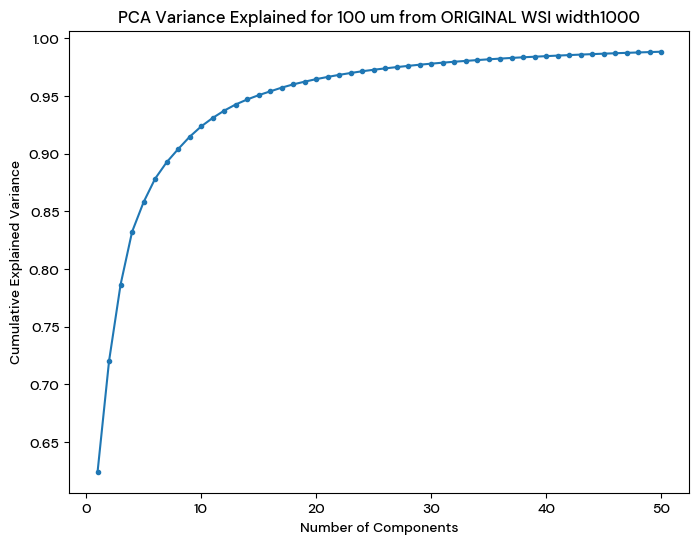

In [14]:
from utils_clust_n_class import pca_cumulative_variance_plot

plot = pca_cumulative_variance_plot(merged_selected_pickle_df_100um, normalisation_name, TILE_SIZE)
plot.show()

Then let's have a quick visualisation of the PCA, UMAP and tSNE plots.

/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:159: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:159: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:159: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')


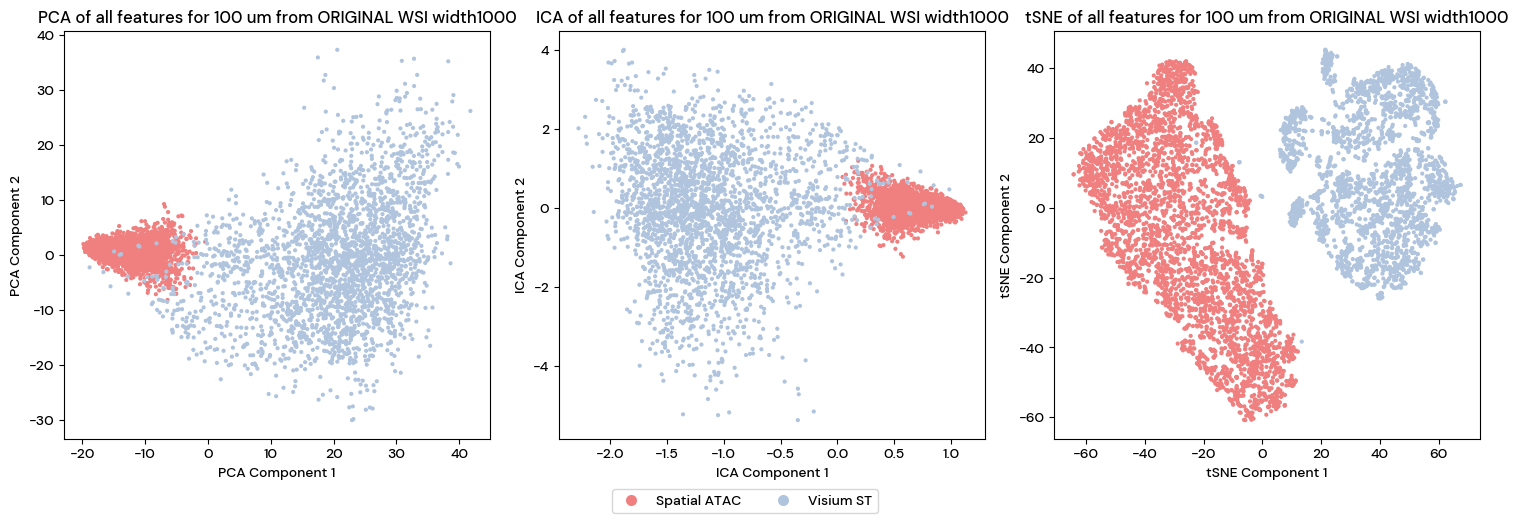

In [15]:
from utils_clust_n_class import all_dim_red

COLORS_FOR_SPATIALS = {"Spatial ATAC": "lightcoral", "Visium ST": "lightsteelblue"}

plot_100, dim_red_results_100 =  all_dim_red(merged_selected_pickle_df_100um, normalisation_name, COLORS_FOR_SPATIALS, TILE_SIZE, selected_methods = ["PCA", "ICA", "tSNE"])
plot_100.show()

In [16]:
plot_100.savefig(os.path.join(PATH_TO_FIGURES, f"plot_all_dimensionality_reductions_{TILE_SIZE}um_{normalisation_name.replace(' ', '_')}.pdf"),
                format="PDF", bbox_inches='tight')

So, we can say that the normalisation is necessary.

---

## 2.2 - For 68 μm tiles

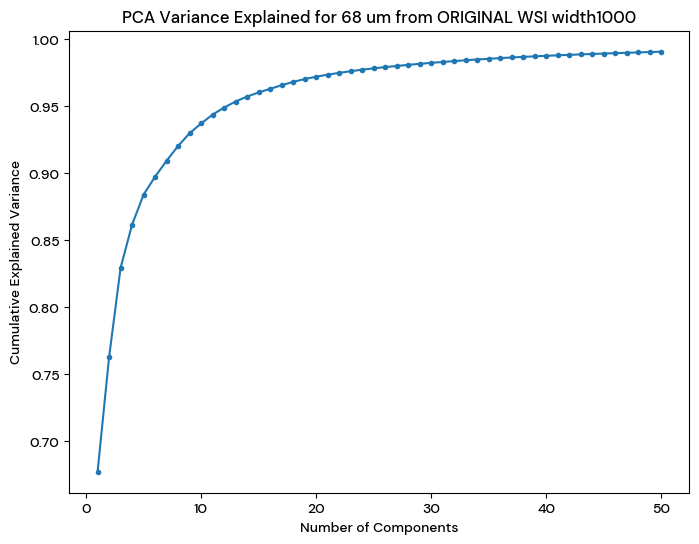

In [17]:
from utils_clust_n_class import pca_cumulative_variance_plot

plot = pca_cumulative_variance_plot(merged_selected_pickle_df_68um, normalisation_name, SPOT_SIZE)
plot.show()

Then let's have a quick visualisation of the PCA, UMAP and tSNE plots.

/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:159: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:159: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:159: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')


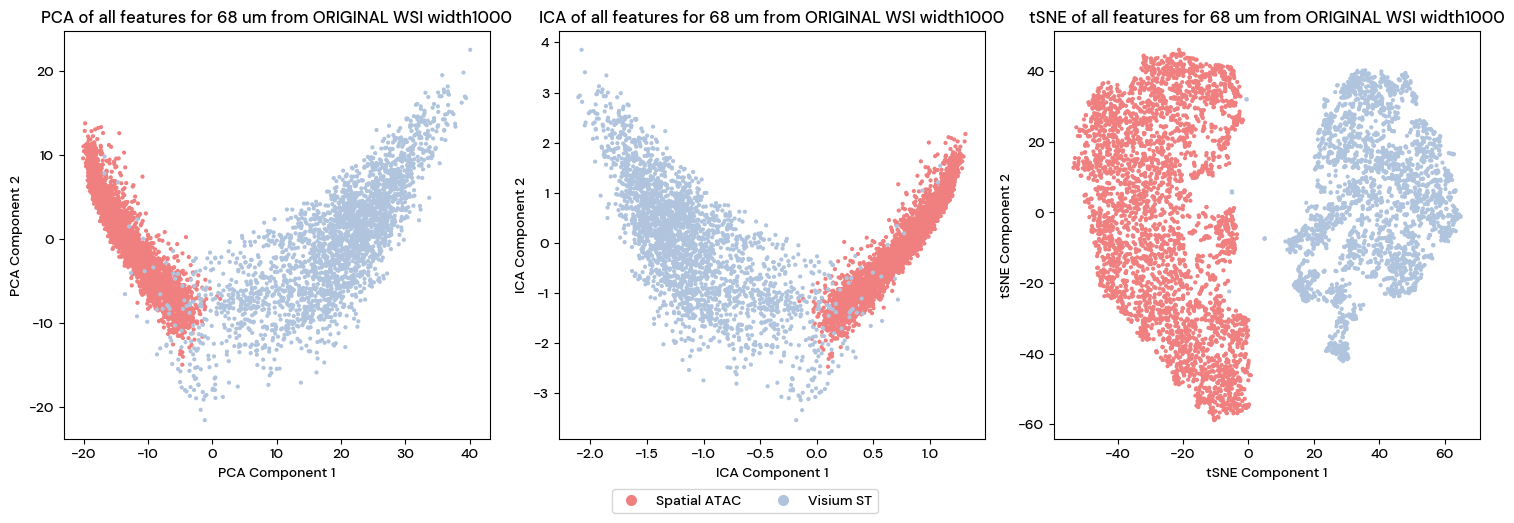

In [18]:
from utils_clust_n_class import all_dim_red

COLORS_FOR_SPATIALS = {"Spatial ATAC": "lightcoral", "Visium ST": "lightsteelblue"}

plot_68, dim_red_results_68 =  all_dim_red(merged_selected_pickle_df_68um, normalisation_name, COLORS_FOR_SPATIALS, SPOT_SIZE, selected_methods = ["PCA", "ICA", "tSNE"])
plot_68.show()

In [19]:
plot_68.savefig(os.path.join(PATH_TO_FIGURES, f"plot_all_dimensionality_reductions_{SPOT_SIZE}um_{normalisation_name.replace(' ', '_')}.pdf"), 
                format="PDF", bbox_inches='tight')

So, we can say that the normalisation is necessary.